# Analyzing NYC High School Data for Efficacy of Standardized Tests

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/NYC_DOE_Logo.png/1200px-NYC_DOE_Logo.png" width="400" height="400" />

*Source*: [wikipedia.org](https://en.wikipedia.org/wiki/New_York_City_Department_of_Education)

In this project, we'll be using data about New York City public schools, which can be found [here](https://data.cityofnewyork.us/browse?category=Education).

One of the most controversial issues in the US educational system is the efficacy of standardized tests and whether they're unfair to certain groups. Given our prior knowledge of this topic, investigating the correlations between [SAT scores](https://en.wikipedia.org/wiki/SAT) and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

## Project Overview

The SAT (Scholastic Aptitude Test), is an exam that US high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's important to perform well.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible (while this number has changed a few times, the dataset for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) available online, as well as the [demographic for each high school](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2). This first few rows of the SAT data look like this:

![](https://s3.amazonaws.com/dq-content/sat.png)

*source*: [Dataquest](https://www.dataquest.io/new-home/)

## Data Sources

Unfortunately, combining both of the datasets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do our full analysis.

The same website has several related datasets covering demographic information and test scores. Here are the links to all of the datasets we'll be using:

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

All of these datasets are interrelated. We'll need to combine them into a single dataset before we can find correlations.

## Background Research on Topic

Before we move into coding, we'll need to do a thorough research to understand the data. This can help us avoid costly mistakes, such as thinking that a column represents something other than what it does. Background research gives us a better understanding of how to combine and analyze the data.

In our case, we'll want to research:

- [New York City](https://en.wikipedia.org/wiki/New_York_City)
- [The SAT](https://en.wikipedia.org/wiki/SAT)
- [Schools in New York City](https://en.wikipedia.org/wiki/List_of_high_schools_in_New_York_City)
- [Our data](https://data.cityofnewyork.us/browse?category=Education)

We can learn a few different things from these resources, For example:

- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contain dozens of schools.
- Our datasets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a `DBN` or district borough number.
- Aggregating data by district allows us to use the district mapping data to plot district-by-district differences.

## Import Libraries and Read in Datasets

In our first step, we'll import the libraries that are useful to work with the datasets.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

We've imported the libraries and now we're ready to read in the data. For the convenience, we've placed all the data into the `schools` folder. Here are all of the files in the folder:

- `ap_2010.csv` - Data on [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)
- `class_size.csv` - Data on [class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
- `demographics.csv` - Data on [demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)
- `graduation.csv` - Data on [graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a)
- `hs_directory.csv` - A directory of [high schools](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2)
- `sat_results.csv` - Data on [SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4)
- `survey_all.txt` - Data on [surveys](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) from all schools
- `survey_d75.txt` - Data on [surveys](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) from New York City district 75

`survey_all.txt` and `survey_d75.txt` are in more complicated formats than the other files. For now, we'll focus on reading in the `CSV` files only, and then explore them.

We'll read each file into a [pandas.dataframe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) and then store all of the dataframes in a dictionary. This gives us a convenient way to store them and a quick way to reference them later on.

In [2]:
# Create a list 'data_files' to store all files
data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv']

# Create a dictionary 'data' to store filename as the key
# and the corresponding dataframe as its value
data = {}

for file in data_files:
    # read file as pandas dataframe
    df = pd.read_csv(f'schools/{file}')
    # extract file name
    filename = file.replace('.csv', '')
    # store filename and corresponding dataframe
    data[filename] = df

What we're mainly interested in is the SAT dataset, which corresponds to the directory key `sat_results`. This dataset contains the SAT scores for each high school in New York City. We eventualy want to correlate selected information from this dataset with information in the other datasets.

Let's explore `sat_results` to see what we can discover. Exploring the dataframe helps us understand the structure of the data and make it easier for us to analyze it.

In [3]:
# Display the first five rows of the 'SAT scores' data
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can make a few observations based on the output above:

- The `DBN` appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each `DBN` is unique in the SAT data.
- We may eventually want to combine the three columns that contian SAT scores -- `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` -- into a single column to make the scores easier to analyze.

Given these observations, let's explore the other datasets to see if we can gain any insight into how to combine them.

In [4]:
# Display the first five rows of each dataframe in the 'data' dictionary
for k in data:
    print(data[k].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

With these group of dataframes, we can make some observations based on the first few rows of each one.

- Each dataset appears to either have a `DBN` column or the information we need to create one. That means we can use a `DBN` column to combine the datasets. First we'll pinpoint matching rows from different datasets by looking for identical `DBN`s, then group all of their columns together in a single dataset.
- Some fields look interesting for mapping -- particularly `Location 1`, which contains coordinates inside a larger string.
- Some of the datasets appear to contain multiple rows for each school (because the rows have duplicate `DBN` values). That means we'll have to do some preprocessing to ensure that each `DBN` is unique within each dataset. If we don't do this, we'll run into problems when we combine the datasets, because we might be merging two rows in one dataset with one row in another dataset.

Before we proceed with the merge, we should make sure we have all of the data we want to unify. We mentioned the survey data earlier (`survey_all.txt` and `survey_d75.txt`), but we didn't read those files in because they're in a slightly more complex format. The files are *tab delimited* and encoded with `Windows-1252` encoding. An encoding defines how a computer stores the contents of a file in binary.

## Read in the surveys

We'll need to specify the encoding and delimiter to the pandas [pandas.read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) function to ensure it reads the surveys in properly.

After we read in the survey data, we'll want to combine it into a single dataframe. We can do this by calling the [pandas.concat()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html).

In [5]:
# Read in 'survey_all.txt'
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')

# Read in 'survey_d75.txt'
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')

# Combine 'd75_survey' and 'all_survey' into a single dataframe
survey = pd.concat([all_survey, d75_survey], axis=0)

# Display the first five rows of 'survey'
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are two immediate facts that we can see in the output of `survey` dataframe:

- There are over `2000` columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns makes it easier to print the dataframe out and find correlations within it.
- The survey data has a `dbn` column that we'll want to convert to uppercase (`DBN`). The conversion makes the column name consistent with the other datasets.

## Data Cleaning

### 1. Filter Columns in survey dataset

We'll need to filter the columns to remove the ones we don't need. Luckily, there's a data dictionary at the [original data download location](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8). The dictionary tells us what each column represents. Based on our knowledge of the problem and the analysis we're trying to do, we can use the data dictionary to determine which columns to use.

Here's a preview of the data dictionary:

<img src="https://s3.amazonaws.com/dq-content/xj5ud4r.png" width="800" height="800" />

*Source*: [Dataquest](https://www.dataquest.io/new-home/)

Based on the dictionary, it looks like these are the relevant columns:

```
["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
```

These columns give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It also gives us the `DBN`, which allows us to uniquely identify the school.

Before we filter columns out, we'll want to copy the data from the `dbn` column into a new column called `DBN`.

In [6]:
# # Copy 'survey' dataframe to a new dataframe to avoid 'PerformanceWarning'
# survey2 = survey.copy()

# Copy the data from the 'dbn' column of 'survey' into new column called 'DBN'
survey['DBN'] = survey['dbn']

# Create the list of target columns
# note we want target the 'DBN' column instead of 'dbn' 
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t",
                 "N_p", "saf_p_11", "com_p_11", "eng_p_11",
                 "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11",
                 "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11",
                 "aca_s_11", "saf_tot_11", "com_tot_11",
                 "eng_tot_11", "aca_tot_11"]

# Filter 'survey2' so it only contains the columns listed above
survey = survey.loc[:, survey_fields]

# Assign 'survey2' dataframe to the key 'survey' in the dictionary 'data'
data['survey'] = survey

# Display result
display(data['survey'].head())

# View the number of rows and columns
print(f"Number of rows and columns in survey dataset:\n{data['survey'].shape}")

C:\Users\awon\AppData\Local\Temp\ipykernel_8084\1187748925.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey['DBN'] = survey['dbn']


,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


Number of rows and columns in survey dataset:
(1702, 23)


After filtering the columns, the `data['survey']` dataframe has `23` columns and `1702` columns.

### 2. Add "DBN" Column for "class_size" and "hs_directory" datasets

When we explored all of the datasets, we noticed that some of them, like `class_size` and `hs_directory`, don't have a `DBN` column. `hs_directory` does have a `dbn` column, though, so we can just rename it.

However, `class_size` doesn't appear to have the column at all. Here are the first few rows of the dataset:

In [7]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


And below are the first few rows of the `sat_results` data, which does have a `DBN` column:

In [8]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


From looking at these rows, we can tell that the `DBN` in the `sat_results` data is just a combination of the `CSD` and `SCHOOL CODE` columns in the `class_size` data. The main difference is that the `DBN` is padded, so that the `CSD` portion of it always consists of two digits. That means we'll need to add a leading `0` to the `CSD` if the `CSD` is less than two digits long. Here's a diagram illustrating what we need to do:

| CSD | Padded CSD |
| --- | :---: |
| 1 | 01 |
| 19 | 19 |
| 2 | 02 |
| 99 | 99 |

As we can see, whenever the `CSD` is less than two digits long, we need to add a leading `0`. We can accomplish this using the [pandas.Series.apply()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html) method, along with a common function that:

- Takes in a number.
- Converts the number to a string using the [str()](https://docs.python.org/3/library/stdtypes.html#str) function.
- Checks the length of the string using the [len()](https://docs.python.org/3/library/functions.html#len) function.
    - If the string is two digits long, returns the string.
    - If the string is one digit long, adds a `0` to the front of the string, then returns it.
        - We can use the string method [zfill()](https://docs.python.org/3/library/stdtypes.html#str.zfill) to do this.

Once we've padded the `CSD`, we can use the addition operator (`+`) to combine the values in the `CSD` and `SCHOOL CODE` columns. Here's a diagram illustrating the basic concept:

| Padded CSD |  | School Code |  | DBN |
| :---: | :---: | :---: | :---: | :---: |
| 01 |  | M015 |  | 01M015 |
| 19 | + | M022 | = | 19M022 |         
| 02 |  | M016 |  | 02M016 |
| 99 |  | M025 |  | 99M025 |

Before manipulating data in the `class_size` dataframe, first we'll copy the `dbn` column in `hs_directory` into a new column called `DBN`.

In [9]:
# Access 'data' directionary to copy column inthe 'hs_directory'
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

# View the first five rows of 'hs_directory'
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\r\nBrooklyn, NY 11225\r\n(4...",17K548
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\r\nBronx, NY 10456\r\n(40.827...",09X543
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\r\nBronx, NY 10452\r\n(40.8...",09X327
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\r\nNew York, NY 10038\r\n(40....",02M280
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to Queens students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\r\nJamaica, NY 11432\r\...",28Q680


Next we'll create a new column called `padded_csd` in the `class_size` dataset. We'll use `pandas.Series.apply()` method along with a custom function `check_num()` to generate this column.

In [10]:
def check_num(num):
    """
    Convert the integer number into string then add a zero (0) in the beginning of the number
    if the length is less than two.
    
    Param (int):
        The number can have one or more digits.
    
    Returns (str):
        The returned number has two digits atleast.
    """
    return str(num).zfill(2)

# Create new column 'padded_csd' in 'class_size'
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(check_num)

# Add 'padded_csd' and 'SCHOOL CODE' to create 'DBN' column
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Display first five rows of 'class_size' dataframe
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


### 3. Add SAT Column in "sat_results" dataset

Now, let's take some time to calculate variable that are useful in our analysis. We've already discussed one such variable -- a column that totals up the SAT scores for the different sections of the exam. This makes it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

Before we can generate this column, we'll need to convert the `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the `sat_results` dataset from the object (string) data type to a numeric data type. We can use [pandas.to_numeric()](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.to_numeric.html) method for the conversion. If we don't convert the values, we won't be able to add the columns together.

It's important to pass the keyword argument `errors="coerce"` when we call `pandas.to_numeric()`, so that pandas treats any invalid strings it can't convert to numbers an missing values instead.

After we perform the conversion, we can use [pandas.DataFrame.sum()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) to add all three columns together. We'll also make sure to pass `skipna=False` in the `sum()` method otherwise the sum method will replace `NaN` with `0` which we want to avoid for now. We'll handle the missing values later.

In [11]:
# Create a list of target columns
sat_cols = ['SAT Math Avg. Score',
            'SAT Critical Reading Avg. Score',
            'SAT Writing Avg. Score']

# Convert the data type to numeric of the target columns
# and assign the result back to the same column
for col in sat_cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors='coerce')
    
# Create a column 'sat_score' in 'sat_results'
# that holds the combined SAT score
data['sat_results']['sat_score'] = data['sat_results'][sat_cols].sum(axis=1, skipna=False)

# Display first five rows
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


### 4. Add latitiude and longitude columns in "hs_directory"

Now we'll want to parse the latitude and longitude coordinates for each school. This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` dataset.

Let's take a look at the first few rows:

In [12]:
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\r\nBrooklyn, NY 11225\r\n(4...
1    1110 Boston Road\r\nBronx, NY 10456\r\n(40.827...
2    1501 Jerome Avenue\r\nBronx, NY 10452\r\n(40.8...
3    411 Pearl Street\r\nNew York, NY 10038\r\n(40....
4    160-20 Goethals Avenue\r\nJamaica, NY 11432\r\...
Name: Location 1, dtype: object

As we can see, this field contains a lot of information we don't need. We want to extract the coordinates, which are in parentheses at the end of the field. Here's an example:

In [13]:
data['hs_directory']['Location 1'].iloc[1]

'1110 Boston Road\r\nBronx, NY 10456\r\n(40.8276026690005, -73.90447525699966)'

We want to extract the latitude, `40.8276026690005`, and the longitude, `-73.90447525699966`. Taken together, latitude and longitude make up a pair of coordinates that allows us to pinpoint any location on Earth.

We can do the extraction with a regular expression. This following expression pulls out everything inside the parentheses:

In [14]:
# Extract coordinates at first index of 'Lacation 1'
data['hs_directory']['Location 1'].str.findall("\(.+\)")[0]

['(40.67029890700047, -73.96164787599963)']

This command returns a list of coordinates. We'll need to process this result further using the string methods [split()](https://docs.python.org/3/library/stdtypes.html#str.split) and [replace()](https://docs.python.org/3/library/stdtypes.html#str.replace) methods to extract each coordinate.

In [15]:
def extract_coords(field_info, indx, pat=r'\(.+\)'):
    """
    Extract the coordinates for each school from
    'Location 1' column and split them into latitude and longitude.
    
    Params:
        field_info (str): The information of school, e.g. address, coordinates, etc
        indx (int): Index number to extract latitude and longitude
        pat (regex): Regular Expression to extract everything inside the parentheses of 'field_info'
        
    Return:
        If the indx is 0 return latitude values otherwise return the longitude
    """
    if indx == 0:
        return re.findall(pat, field_info)[0].split(',')[indx].replace('(', '')
    elif indx == 1:
        return re.findall(pat, field_info)[0].split(',')[indx].replace(')', '').strip()
    
# Extract latitude and assign values to new column 'lat' of 'hs_directory'
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(extract_coords, indx=0)

# Extract longitude and assign values to new column 'lon' of 'hs_directory'
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(extract_coords, indx=1)

# Display the result
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\r\nBrooklyn, NY 11225\r\n(4...",17K548,40.67029890700047,-73.96164787599963
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\r\nBronx, NY 10456\r\n(40.827...",09X543,40.8276026690005,-73.90447525699966
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\r\nBronx, NY 10452\r\n(40.8...",09X327,40.842414068000494,-73.91616158599965
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\r\nNew York, NY 10038\r\n(40....",02M280,40.71067947100045,-74.00080702099967
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\r\nJamaica, NY 11432\r\...",28Q680,40.718810094000446,-73.80650045499965


We have the both coordinates, `lat` and `lon`. Next, we'll need to convert them to numeric values. We can use the `pandas.to_numeric()` function to convert them from strings to numbers.

In [16]:
# List of the target columns
coords_cols = ['lat', 'lon']

for col in coords_cols:
    data['hs_directory'][col] = pd.to_numeric(data['hs_directory'][col], errors='coerce')
    
# Check the data type of 'lat' and 'lon' column (should be float type)
data['hs_directory'][['lat', 'lon']].dtypes

lat    float64
lon    float64
dtype: object

### 5. Make Unique "DBN" Value in Each Dataset

So far we have manipulated several datasets and found that we could combine them using the `DBN` column. All of the datasets are currently stored as keys in the `data` dictionary where each dataset is a pandas dataframe.

However, we'll need to do some more data cleaning before combining these datasets. Then, we'll compute correlations and perform some analysis.

The first thing we'll need to do in preparation for the merge is condense some of the datasets. In the last lesson, we noticed that the values in the `DBN` column were unique in the `sat_results` dataset. Other datasets like `class_size` had duplicate `DBN` values.

We'll need to condense these datasets so that each value in the `DBN` column is unique. If not, we'll run into issues when it comes time to combine the datasets.

While the main dataset we want to analyze, `sat_results`, has unique `DBN` values for every high school in New York City, other datasets aren't as clean. A single row in the `sat_results` dataset may match multiple rows in the `clean_size` dataset, for example. This situation creates problems, because we don't know which of the multiple entries in the `clean_size` dataset we should combine with the single matchin entry in `sat_results`. Below is a table that illustrates the problem:

| sat_results |  |  | class_size |  |
| :---: | :---: | :---: | :---: | :---: |
| **DBN** | ... |  | **DBN** | ... |
| 01M022 | ... |  | 01M022 | ... |
| 05M345 | ... | + | 01M022 | ... |
| 02M456 | ... |  | 05M345 | ... |
| 99M520 | ... |  | 05M345 | ... |

In the table above, we can't combine the rows from both datasets, because there are several cases where multiple rows in `class_size` match a single row in `sat_results`.

To resolve this issue, we'll condense the `class_size`, `graduation` and `demographics` datasets so that each `DBN` is unique.

### 5.1 Unique "DBN" in "class_size" dataset

The first dataset that we'll condense is `class_size`. The first few rows of the `class_size` look like this:

In [17]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


As we can see, the first few rows all pertain to the same school, which is why the `DBN` appears more than once. It looks like each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`.

If we look at the unique values for `GRADE`, we get the following:

In [18]:
data['class_size']['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Since we're dealing with high schools, we're only concerned with grades `9` through `12`. That means we only want to pick rows where the value in the `GRADE` column is `09-12`.

If we look at the unique values for `PROGRAM TYPE`, we get the following:

In [19]:
data['class_size']['PROGRAM TYPE'].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

Each school can have multiple program types. Since `GEN ED` is the largest category by far, let's only select rows where `PROGRAM TYPE` is `GEN ED`.

In [20]:
# Create a new variable 'class_size' and assign the value of
# data['class_size'] to it
class_size = data['class_size']

# Filter 'class_size' so the 'GRADE' column only contains the value '09-12'
# also filter the dataset where the values are 'GEN ED' in 'PROGRAM TYPE' column
class_size = (class_size[(class_size['GRADE '] == '09-12') &
             (class_size['PROGRAM TYPE'] == 'GEN ED')])

# Display first five rows
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


As we can see the result of `class_size` above, the `DBN` column still isn't completely unique. This is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns. These columns seem to pertain to different kinds of classes. For example, here are the unique values for `CORE SUBJECT (MS CORE and 9-12 ONLY)`:

In [21]:
class_size['CORE SUBJECT (MS CORE and 9-12 ONLY)'].unique()

array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)

This column only seems to include certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This gives us unique `DBN` values, while also incorporating as much data as possible into the average.

Fortunately, we can use the [pandas.DataFrame.groupby()](http://pandas.pydata.org/pandas-docs/stable/groupby.html) method to help us with this. The `DataFrame.groupby()` method splits a dataframe up into unique groups, based on a given column. We can then use the [agg()](http://pandas.pydata.org/pandas-docs/stable/groupby.html#aggregation) method on the resulting `pandas.core.groupby` object to find the mean of each column.

Let's say we have this dataset:

| DBN    | CORE SUBJECT (MS CORE and 9\|12 ONLY) | AVERAGE CLASS SIZE |
|--------|:---------------------------------------|:--------------------|
| 01M292 | ENGLISH                               | 21.0               |
| 01M292 | ENGLISH                               | 26.3               |
| 01M292 | ENGLISH                               | 19.0               |
| 01M292 | ENGLISH                               | 23.0               |
| 01M292 | MATH                                  | 17.7               |
| 01M292 | MATH                                  | 32.0               |
| 01M292 | MATH                                  | 19.7               |
| 01M292 | SCIENCE                               | 31.3               |
| 01M292 | SCIENCE                               | 29.0               |
| 01M292 | SCIENCE                               | 19.6               |
| 01M292 | SCIENCE                               | 13.0               |
| 01M292 | SCIENCE                               | 21.3               |
| 01M292 | SOCIAL STUDIES                        | 22.3               |
| 01M292 | SOCIAL STUDIES                        | 20.7               |
| 01M332 | ENGLISH                               | 20.0               |
| 01M332 | ENGLISH                               | 24.0               |
| 01M378 | MATH                                  | 33.0               |
| 01M448 | ENGLISH                               | 17.7               |
| 01M448 | ENGLISH                               | 16.6               |
| 01M338 | ENGLISH                               | 21.3               |

Using the `groupby()` method, we'll split this dataframe into four separate groups -- one with the `DBN` `01M292`, one with the `DBN` `01M332`, one with the `DBN` `01M378`, and one with the `DBN` `01M448`:

| DBN    | CORE SUBJECT (MS CORE and 9\|12 ONLY) | AVERAGE CLASS SIZE |
|--------|:---------------------------------------|:--------------------|
| 01M292 | ENGLISH                               | 21.0               |
| 01M292 | ENGLISH                               | 26.3               |
| 01M292 | ENGLISH                               | 19.0               |
| 01M292 | ENGLISH                               | 23.0               |
| 01M292 | MATH                                  | 17.7               |
| 01M292 | MATH                                  | 32.0               |
| 01M292 | MATH                                  | 19.7               |
| 01M292 | SCIENCE                               | 31.3               |
| 01M292 | SCIENCE                               | 29.0               |
| 01M292 | SCIENCE                               | 19.6               |
| 01M292 | SCIENCE                               | 13.0               |
| 01M292 | SCIENCE                               | 21.3               |
| 01M292 | SOCIAL STUDIES                        | 22.3               |
| 01M292 | SOCIAL STUDIES                        | 20.7               |

| DBN    | CORE SUBJECT (MS CORE and 9\|12 ONLY) | AVERAGE CLASS SIZE |
|--------|:---------------------------------------|:--------------------|
| 01M332 | ENGLISH                               | 20.0               |
| 01M332 | ENGLISH                               | 24.0               |

| DBN    | CORE SUBJECT (MS CORE and 9\|12 ONLY) | AVERAGE CLASS SIZE |
|--------|:---------------------------------------|:--------------------|
| 01M378 | MATH                                  | 33.0               |

| DBN    | CORE SUBJECT (MS CORE and 9\|12 ONLY) | AVERAGE CLASS SIZE |
|--------|:---------------------------------------|:--------------------|
| 01M448 | ENGLISH                               | 17.7               |
| 01M448 | ENGLISH                               | 16.6               |
| 01M448 | ENGLISH                               | 21.3               |

Then, we can compute the averages for the `AVERAGE CLASS SIZE` column in each of the four groups using the `agg()` method:

| DBN    | AVERAGE CLASS SIZE |
|--------|:--------------------|
| 01M292 | 22.564286          |
| 01M332 | 22.000000          |
| 01M378 | 33.000000          |
| 01M448 | 18.533333          |

After we group a dataframe and aggregate data based on it, the column we performed the grouping on (in this case `DBN`) becomes the index and no longer appears as a column in the data itself. To undo this change and keep `DBN` as a column, we'll need to use [pandas.DataFrame.reset_index()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html). This method resets the index to a list of integers and make `DBN` a column again.

In [22]:
# Find average of each column associated with each 'DBN' in 'class_size'
class_size = class_size.groupby('DBN').agg(np.mean)

# Reset the index to make 'DBN' a column again
class_size.reset_index(inplace=True)

# Assign the result back to the 'class_size' key of the 'data' dictionary
data['class_size'] = class_size

# Display result to verify changes
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1.0,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1.0,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1.0,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1.0,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1.0,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### 5.2 Unique "DBN" in "demographics" dataset

Let's move on and condense `demographics`. This first few rows look like this:

In [23]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is `20112012`. This will give us the most recent year of data, and also match our SAT results data.

In [24]:
# Filter rows where 'schoolyear' is '20112012' in 'demographics'
# note that the 'schoolyear' data type is integer
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

# Display the result
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### 5.3 Unique "DBN" in "graduation" dataset

Finally, we'll need to condense the `graduation` dataset. Here are the first few rows:

In [25]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


The `Demographic` and `Cohort` columns are what prevent `DBN` from being unique in the `graduation` data. A `Cohort` appears to refer to the year the data represents, and the `Demographic` appears to refer to a specific demographic group. In this case, we want to pick data from the most recent `Cohort` available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is `Total Cohort`.

In [26]:
# Filter rows where 'Cohort' column equals '2006'
# and 'Demographic' column equals 'Total Cohort'
data['graduation'] = (data['graduation'][(data['graduation']['Cohort'] == '2006') &
                                         (data['graduation']['Demographic'] == 'Total Cohort')])

# Display the results
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


In [27]:
data["graduation"].shape

(405, 23)

### 6. Convert AP Scores to Numeric

We're almost ready to combine all the datasets. The last thing to do is convert the [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a `1` to `5` scale; `3` or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are rarer in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the `ap_2010` dataset to numeric values first.

There are three columns we'll need to convert:

- `AP Test Takers` (note that there's trailing space in the column name)
- `Total Exams Taken`
- `Number of Exams with scores 3 4 or 5`

In [28]:
# Create a list of target columns
ap_test_cols = ['AP Test Takers ',
               'Total Exams Taken',
               'Number of Exams with scores 3 4 or 5']

# Convert each target column in 'ap_2010' dataset to numeric values
for col in ap_test_cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

# Display the column types
data['ap_2010'].dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

## Combine the Data

Before we merge our data, we'll need to decide on the merge strategy we want to use. We'll be using the pandas [pandas.DataFrame.merge()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function, which supports four types of joins -- `left`, `right`, `inner`, and `outer`. Each of these join types dictates how pandas combines the rows.

We'll be using the `DBN` column to identify matching rows across datasets. In other words, the values in that column help us know which row from the first dataset to combine with which row in the second dataset.

There may be `DBN` values that exist in one dataset but not in another. This is partly because the data is from different years. Each dataset also has inconsistencies in terms of how it was gathered. Human error (and other types of errors) may also play a role. Therefore, we may not find matches for the `DBN` values in `sat_results` in all of the other datasets and other datasets may have `DBN` values that don't exist in `sat_results`.

We'll merge two datasets at a time. For example, we'll merge `sat_results` and `hs_directory`, then merge the result with `ap_2010`, then merge the result of that with `class_size`. We'll continue combining datasets in this way until we've merged all of them. Afterwards, we'll have roughly the same number of rows, but each row has columns from all of the datasets.

The merge strategy we pick affects the number of rows we end up with. Let's take a look at each strategy.

Let's say we're merging the following two datasets:

In [29]:
# Create a dummy dataframe 'sat_results'
sat_results = pd.DataFrame({'DBN': ['01', '03', '99', '101'],
                            'sat_score': [1800, 2200, 1600, 2300]})

sat_results

,DBN,sat_score
0,01,1800
1,03,2200
2,99,1600
3,101,2300


In [30]:
# Create a dummy dataframe 'class_size'
class_size = pd.DataFrame({'DBN': ['01', '03', '55', '101'],
                           'avg_class_size': [20, 30, 50, 30]})

class_size

,DBN,avg_class_size
0,01,20
1,03,30
2,55,50
3,101,30


With an `inner` merge, we'd only combine rows where the same `DBN` exists in both datasets. We'd end up with this result:

In [31]:
# Perform 'inner' merge to combine 'sat_results' and 'class_size'
sat_results.merge(right=class_size, how='inner', on='DBN')

,DBN,sat_score,avg_class_size
0,01,1800,20
1,03,2200,30
2,101,2300,30


With a `left` merge, we'd only use `DBN` values from the dataframe on the "left" of the merge. In this case, `sat_results` is on the left. Some of the DBNs in `sat_results` don't exist in `class_size`, though. The merge handles this by assigning null values to the columns in `sat_results` that don't have corresponding data in `class_size`.

In [32]:
# Perform 'left' merge to combine 'sat_results' and 'class_size'
sat_results.merge(right=class_size, how='left', on='DBN')

,DBN,sat_score,avg_class_size
0,01,1800,20.0
1,03,2200,30.0
2,99,1600,NaN
3,101,2300,30.0


With a `right` merge, we'll only use `DBN` values from the dataframe on the "right" of the merge. In this case, `class_size` is on the right:

In [33]:
# Perform 'right' merge to combine 'sat_results' and 'class_size'
sat_results.merge(right=class_size, how='right', on='DBN')

,DBN,sat_score,avg_class_size
0,01,1800.0,20
1,03,2200.0,30
2,55,NaN,50
3,101,2300.0,30


With an `outer` merge, we'll take any `DBN` values from either `sat_results` or `class_size`:

In [34]:
# Perform 'outer' merge to combine 'sat_results' and 'class_size'
sat_results.merge(right=class_size, how='outer', on='DBN')

,DBN,sat_score,avg_class_size
0,01,1800.0,20.0
1,03,2200.0,30.0
2,99,1600.0,NaN
3,101,2300.0,30.0
4,55,NaN,50.0


As we can see, each merge strategy has its advantages. Depending on the strategy we choose, we may preserve rows at the expense of having more missing column data or minimize missing data at the expense of having fewer rows. Choosing a merge strategy is an important decision; it's worth thinking about our data carefully and what trade-offs we're willing to make.

Since our project is concerned with determining demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from `sat_results` while minimizing null values.

This means that we may need to use different merge strategies with different datasets. Some of the datasets have a lot missing `DBN` values. This makes a `left` join more appropriate, because we don't want to lose too many rows when we merge. If we did an `inner` join, we would lose the data for many high schools.

Some datasets have `DBN` values that are almost identical to those in `sat_results`. Those datasets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from `demographics`, for example. Therefore, we'll do an `inner` join to avoid missing data in these columns.

### 1. Combine "sat_results", "ap_2010", and "graduation" datasets

Both `ap_2010` and the `graduation` datasets have many missing `DBN` values, so we'll use a `left` join when we merge the `sat_results` dataset with them. Since we're using `left` join, our final dataframe will have all of the same `DBN` values as the original `sat_results` dataframe.

Because we're using the `DBN` column to join the dataframes, we'll need to specify the keyword argument `on='DBN'` when calling `pandas.DataFrame.merge()`.

First, we'll assign `data['sat_results']` to the variable `combined`. Then, we'll merge the other dataframes with `combined`. When we're finished, `combined` has columns from all of the datasets.

In [35]:
# Assign "data['sat_results']" to 'combined' variable
combined = data['sat_results']

# Perform 'left' join on 'ap_2010' data with 'combined' on 'DBN' column
combined = combined.merge(data['ap_2010'], how='left', on='DBN')

# Perform 'left' join on 'graduation' data with 'combined' on 'DBN' column
combined = combined.merge(data['graduation'], how='left', on='DBN')

# View results
display(combined.head())

# Display dataset shape
print(f'Shape of combined dataset: {combined.shape}')

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


Shape of combined dataset: (479, 33)


### 2. Combine "class_size", "demographics", "survey", and "hs_directory" Datasets

Now that we've performed the `left` joins, we still have to merge `class_size`, `demographics`, `survey`, and `hs_directory` into `combined`. Since these files contain information that's more valuable to our analysis and also have fewer missing `DBN` values, we'll use the `inner` join type.

In [36]:
# Create a list to target datasets in the order mentioned above
target_datasets = ['class_size', 'demographics',
                   'survey', 'hs_directory']

# Perform 'inner' join on 'target_datasets' with 'combined' on 'DBN' column
for dataset in target_datasets:
    combined = combined.merge(data[dataset], how='inner', on='DBN')
    
# View results
display(combined.head())

# Display dataset shape
print(f'Shape of combined dataset: {combined.shape}')

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\r\nNew York, NY 10002\r\n(40....",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\r\nNew York, NY 10002\r\n(40...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\r\nNew York, NY 10009\r\n(4...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\r\nNew York, NY 10002\r\n(4...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\r\nNew York, NY 10002\r\n(...",40.718725,-73.979426


Shape of combined dataset: (363, 159)


We may have noticed that the inner joins resulted in `116` fewer rows in `sat_results`. This is because pandas couldn't find the `DBN` values that existed in `sat_results` in the other datasets. While this is worth investigating, we're currently looking for high-level correlations, so we don't need to dive into which `DBNs` are missing.

## Handle Missing Data

After combining all the datasets we noticed that we now have many columns with null (`NaN`) values. This is because we chose to do `left` joins, where some columns may not have had data. The dataset also had some missing values to begin with. If we hadn't performed a `left` join, all of the rows with missing data would have been lost in the merge process, which wouldn't have left us with many high schools in our dataset.

There are several ways to handle missing data but for now, we'll just fill in the missing values with the overall mean for the column, like so:

```Python
# Initialize dummy data
dummy_data = [['01', 1800, 20], ['03', 2200, 30],
              ['99', 1600, np.nan], ['55', np.nan, 50],
              ['101', 2300, 30]]

# Create dataframe
df = pd.DataFrame(dummy_data, columns=['DBN', 'sat_score', 'avg_class_size'])

# Output before filling the missing values
	DBN	sat_score	avg_class_size
0	01	 1800.0	  20.0
1	03	 2200.0	  30.0
2	99	 1600.0	  NaN
3	55	 NaN	     50.0
4	101    2300.0      30.0

# Fill missing values with average of the column
df.fillna(df.mean())

# Output after filling the missing values
    DBN	sat_score	avg_class_size
0	01	 1800.0	  20.0
1	03	 2200.0	  30.0
2	99	 1600.0	  32.5
3	55	 1975.0	  50.0
4	101	2300.0	  30.0
```

In the above demonstrate, the mean of the `sat_score` column is `(1800 + 1600 + 2200 + 2300) / 4`, or `1975`, and the mean of the `avg_class_size` is `(20 + 30 + 30 + 50) / 4`, or `32.5`. We replace the missing values with the means of their respective columns, which allows us to proceed with analyses that can't handle missing values (like correlations).

We can fill in missing data in pandas using the [pandas.DataFrame.fillna()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) method. This method replaces any missing values in a dataframe with the values we specify. We can compute the mean of every column using the [pandas.DataFrame.mean()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html) method. If we pass the results of the `df.mean()` method into the `df.fillna()` method, pandas fills in the missing values in each column with the mean of that column.

Note that if a column consists entirely of null or `NaN` values, pandas won't be able to fill in the missing values when we use the `df.fillna()` method along with the `df.mean()` method, because there won't be a mean.

We should fill any `NaN` or null values that remain after the initial replacement with the value `0`. We can do this by passing `0` into the `df.fillna()` method.

In [37]:
# Calculate the mean of all the columns in 'combined' data
# pass 'numeric_only=True' to avoid warning
comb_mean = combined.mean(axis=0, numeric_only=True)

# Fill missing values in 'combined' with 'comb_mean'
combined = combined.fillna(value=comb_mean, axis=0)

# Fill remaining missing values in 'combined' with '0'
combined = combined.fillna(value=0, axis=0)

# Check the results of all numeric columns in 'combined' dataset
# note that numeric columns should not have any missing value
combined.select_dtypes(exclude=['object', 'bool']).isnull().sum().sum()

0

In [38]:
print(f'Shape of combined dataset: {combined.shape}')

Shape of combined dataset: (363, 159)


## Add a School District Column for Mapping

We've finished cleaning and combining our data! We now have a clean dataset we can base our analysis. Mapping the satistics out on a school district level might be an interesting way to analyze them. Adding a column to the dataset that specifies the school district helps us accomplish this.

The school district is just the first two characters of the `DBN`. We can apply our customized function (`get_first_two_chars()`) over the `DBN` column of `combined` that pulls out the first two letters.

In [39]:
def get_first_two_chars(string):
    """
    Extract the first two characters of a DBN
    and returns them
    """
    return string[:2]

# Apply the function to the 'DBN' column of 'combined'
# and assign the results to the 'school_dist' column
combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)

# Display result of 'school_dist'
combined['school_dist'].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

We now have a clean dataset to analyze. We are ready to find correlations and create maps.

## Data Analysis and Visualization

In this section, we'll discover correlations, create plots, and then make maps. The first thing we'll do is find any correlations between columns and `sat_score`. This helps us determine which columns might be interesting to plot out or investigate further. Afterwards, we'll perform more analysis and create maps using the columns we've identified.

Correlations tell us how closely related two columns are. We'll be using the **r value**, also called [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), to measure how closely two sequences of numbers are correlated.

An r value falls between `-1` and `1`. The value determines whether two columns are *positively correlated*, *not correlated*, or *negatively correlated*. The closer to `1` the r value is, the stronger the positive correlation between the two columns. The closer to `-1` the r value is, the stronger the negative correlation (i.e., the more "opposite" the columns are). The closer to `0`, the weaker the correlation.

In general, r values above `.25` or below `-.25` are enough to qualify a correlation as interesting. An r value isn't perfect and doesn't indicate that there's a correlation -- just the possiblity of one. To assess whether a correlation exists, we need to look at the data using a scatterplot to see its "shape". For example, here's a scatterplot with a very strong negative r value of `-.73`:

<img src="https://s3.amazonaws.com/dq-content/correlation.png" width="400" height="400" />

*Source*: [Dataquest](https://www.dataquest.io/)

Notice how in the image above, all of the points appear to fall along a line. This pattern indicates a corralation.

Here's a scatterplot with an r value of `.25`, which indicates a weak correlation:

<img src="https://s3.amazonaws.com/dq-content/no_correlation.png" width="400" height="400" />

*Source*: [Dataquest](https://www.dataquest.io/)

Notice how the data points in the image go in several directions, and there's no clear linear relationship.

Because we're interested in exploring the fairness of the SAT, a strong positive or negative correlation between a demographic factor like race or gender and SAT score would be an interesting result meriting investigation. If men tended to score higher on the SAT, for example, that would indicate that the SAT is potentially unfair to women and vice-versa.

We can use the pandas [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) method to find correlations between columns in a dataframe. The method returns a new dataframe where the index for each column and row is the name of a column in the original dataset.

In [40]:
# Find correlations in the 'combined' dataframe
# and assign the result to 'correlations'
correlations = combined.corr()

# Filter 'correlations' so it only shows correlations for 'sat_score'
correlations = correlations['sat_score']

# Display complete result of the 'correlations'
with pd.option_context("display.max_rows", None):
    display(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Unsurprisingly, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, `SAT Writing Avg. Score`, and `sat_score` are strongly correlated with `sat_score`.

We can also make some other obervations:

- `total_enrollment` has a strong positive correlation with `sat_score`. This is suprising because we'd expect small schools where students recieve more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
    - Other columns that are proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
- Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
- Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).
- There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).
- The percentage of English language learners at the school (`ell_percent`, `frl_percent`) has a strong negative correlation with SAT scores.

### 1. Correlation between "total_enrollment" and "sat_score"

Since enrollment seems to have such a strong correlation, let's make a scatterplot of `total_enrollment` vs `sat_score`. Each point in the scatterplot represents a high school, so we'll be able to see if there are any interesting patterns.

We can plot columns in a dataframe using the [pandas.DataFrame.plot()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) accessor on the dataframe. We can also specify a certain plot type. For example, `df.plot.scatter(x="A", y="b")` creates a scatterplot of columns `A` and `B`. To make our analysis efficient we'll make a custom function `create_scatter()` which can help us to plot scatterplot when we need.

In [41]:
def create_scatter(xcol, xlab, title, ycol='sat_score', ylab='sat_score', figsize=(8, 8),
                   hline=False, ypos=0, xmin=0, xmax=1, vline=False, xpos=0, ymin=0, ymax=1):
    """
    Make the scatterplot and display relationship between SAT score with a specified variable.
    
    Params: xcol (str): Variable on the x-axis
            xlab (str): x-axis label
            title (str): Title of the graph
            ycol (str): Variable on the y-axis (default: 'sat_score')
            ylab (str): y-axis label (default: 'sat_score')
            figsize (tuple): Figure size
            hline (bool): Whether to add horizontal line across axes (default: False)
            ypos (float): y position in data cooridnates of the horizontal line (default: 0)
            xmin (float): Should be between 0 and 1 (default: 0)
            xmax (float): Should be between 0 and 1 (default: 1)
            vline (bool): Whether to add vertical line across axes (default: False)
            xpos (float): x position in data cooridnates of the vertical line (default: 0)
            ymin (float): Should be between 0 and 1 (default: 0)
            ymax (float): Should be between 0 and 1 (default: 1)
            
    Returns: Scatterplot
    """
    combined.plot(kind='scatter', x=xcol, y=ycol, figsize=figsize)
    plt.title(title, fontsize=20, fontweight='bold')
    plt.ylabel(ylab, fontsize=16)
    plt.xlabel(xlab, fontsize=16)
    
    if hline:
        plt.axhline(y=ypos, xmin=xmin, xmax=xmax, linewidth=0.5, color='red', linestyle='-.')
    if vline:
        plt.axvline(x=xpos, ymin=ymin, ymax=ymax, linewidth=0.5, color='red', linestyle='-.')
        
    plt.show()

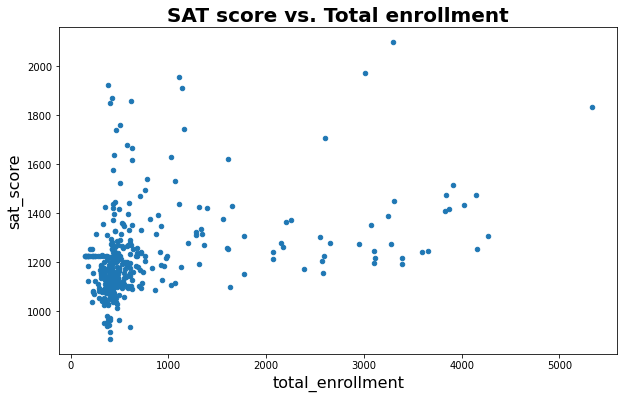

In [42]:
# Create the scatterplot of 'total_enrollment' versus 'sat_score'
create_scatter(xcol='total_enrollment', xlab='total_enrollment', title='SAT score vs. Total enrollment', figsize=(10, 6))

Judging from the plot we just created, it doesn't appear there's a strong correlation between `sat_score` and `total_enrollment`. If there was a strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where `total_enrollment` and `sat_score` are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [43]:
# Filter the 'combined' dataframe to keep only those rows where
# 'total_enrollment' is under '1000' and 'sat_score' is under '1000'
low_enrollment = (combined[(combined['total_enrollment'] < 1000) &
                           (combined['sat_score'] < 1000)])

# Display all of the items in the 'School Name' column
# filter only those rows that have school name other than '0'
low_enrollment[low_enrollment['School Name'] != 0]['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

### 2. Correlation between "ell_percent" and "sat_score"

After using [Wikipedia](https://www.wikipedia.org/) and [Google](https://www.google.com/) to research the names of the schools above, we found out that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually `ell_percent` that correlates strongly with `sat_score`, rather than `total_enrollment`. To explore this relationship further, let's plot out `ell_percent` vs `sat_score`.

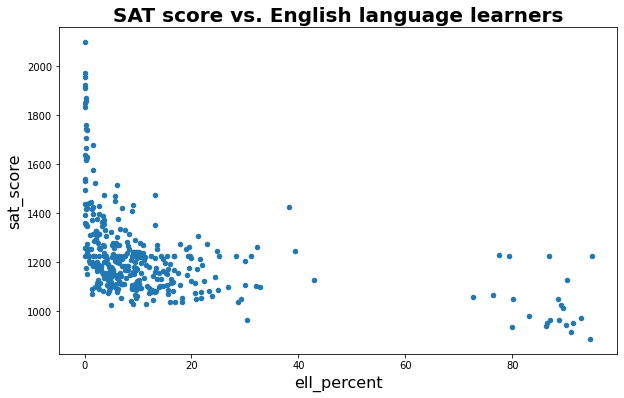

In [44]:
# Create a scatterplot of `ell_percent' versus 'sat_score'
create_scatter(xcol='ell_percent', xlab='ell_percent', title='SAT score vs. English language learners', figsize=(10, 6))

One way to make very granular statistics easier to read is to aggregate them. In this case, we aggregate by district, which enables us to understand how `ell_percent` varies district-by-district instead of the unintelligibly granular school-by-school variation.

### 3. Average for Each School District

In order to achieve this, we'll use the [pandas.DataFrame.groupby()](http://pandas.pydata.org/pandas-docs/stable/groupby.html) method followed by the [agg()](http://pandas.pydata.org/pandas-docs/stable/groupby.html#aggregation) method on the resulting object to find the mean class size for each unique `DBN`. This principle is exactly the same, except that here we'd find the mean of each column for each unique value in `school_dist`.

In [45]:
# Find the average values for each column for each 'school_dist'
# in 'combined' and assign the result to the variable 'districts'
districts = combined.groupby('school_dist').agg(np.mean)

# Reset the index of 'districts', making 'school_dist' a column again
districts.reset_index(inplace=True)

# Display first few result of 'districts'
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as rach, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

There are several fields in `combined` that originally came from a [survey of parents, teachers, and students](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8). Finding correlations between these fields and `sat_score` can be helpful to get more insights.

We can use the list of the fields in the `survey_fields` variable that we created earlier. We'll have to remove `DBN` from the list since it's a unique identifier and not a useful column as numeric value for correlation.

In [46]:
# Slice the list 'survey_fields' and skip first index value
# which is 'DBN'
survey_list = survey_fields[1:]
survey_list

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

We'll create a function `create_bar()` to draw a bar plot so we can use it later when we need it.

In [47]:
def create_bar(target_cols, xlab, ylab, title, kind='bar', is_sorted=False, figsize=(8, 8),
               hline=False, xmin=0, xmax=1, vline=False, ymin=0, ymax=1, **kwargs):
    """
    Make a bar plot and display correlation between SAT score with specified variable(s).
    
    Params: target_cols (list): Columns of interest for correlation
            xlab (str): xaxis label
            ylab (str): yaxis label
            title (str): Title of the graph
            kind (str): Type of plot bar/barh (default: bar)
            is_sorted (bool): Whether to sort the plot (default: False)
            figsize (tuple): Figure size (default: (8, 8))
            hline (bool): Whether to add horizontal line across axes (default: False)
            xmin (float): Begining of the horizontal line (default: 0)
            xmax (float): End of the horizontal line (default: 1)
            vline (bool): Whether to add vertical line across axes (default: False)
            ymin (float): Begining of the vertical line (default: 0)
            ymax (float): End of vertical line (default: 1)
            **kwargs (dict): Dict of list for horizontal and/or vertical line position
    
    Returns: Bar plot
    """
    # Draw bar plot (sorted or unsorted)
    if is_sorted:
        correlations[target_cols].sort_values().plot(kind=kind, figsize=figsize)
    else:
        correlations[target_cols].plot(kind=kind, figsize=figsize)
    
    # Title, x and y-axis label
    plt.title(label=title, fontsize=20, fontweight='bold')
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    
    # Find number of elements in 'correlation[target_cols]'
    corr_len = len(correlations[target_cols])
    
    # Draw horizontal line (also check num of horizontal lines to draw)
    if hline:
        if len(kwargs['hori']) == 2:
            plt.hlines(y=[kwargs['hori'][0], kwargs['hori'][1]], xmin=xmin, xmax=corr_len,
                           linewidth=0.5, color='red', linestyle='-.')
        elif len(kwargs['hori']) == 1:
            plt.hlines(y=kwargs['hori'], xmin=xmin, xmax=corr_len, linewidth=0.5, color='red', linestyle='-.')
        else:
            pass
    
    # Draw vertical line (check num of vertical lines to draw)
    if vline:
        if len(kwargs['vert']) == 2:
            plt.vlines(x=[kwargs['vert'][0], kwargs['vert'][1]], ymin=ymin, ymax=ymax,
                       linewidth=0.5, color='red', linestyle='-.')
        elif len(kwargs['vert']) == 1:
            plt.vlines(x=kwargs['vert'], ymin=ymin, ymax=ymax, linewidth=0.5, color='red', linestyle='-.')
        else:
            pass
   
    plt.show()

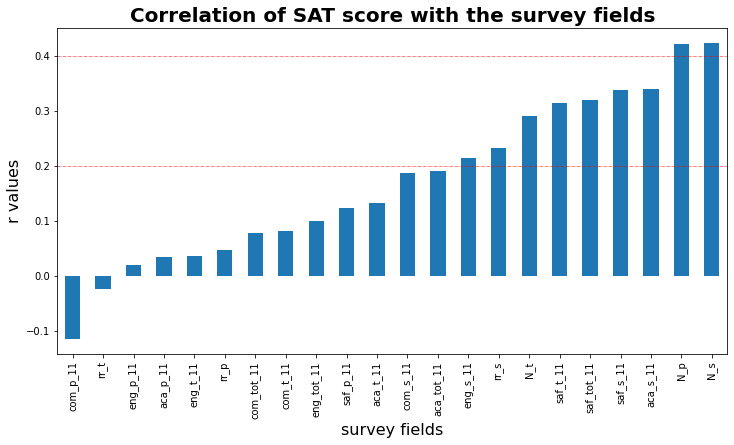

In [48]:
# Create a dict of list for position of the horizontal lines
pos_dict = {'hori': [0.2, 0.4]}

# Create bar plot to display correlation of 'sat_score' and 'survey_list'
create_bar(target_cols=survey_list, xlab='survey fields', ylab='r values',
           title='Correlation of SAT score with the survey fields', is_sorted=True, figsize=(12, 6),
           hline=True, xmin=-0.5, **pos_dict)

The [data dictionary](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) on the City of New York's website gives the following description of these fields (where it seems a safe assumption that the above fields have the same meaning and there only be a difference in year, e.g. `aca_tot_10` and `aca_tot_11` or `eng_s_10` and `end_s_11`):

| **Field Name** | **Field Description**                                  |
|:----------------:|--------------------------------------------------------:|
| rr_s           | Student Response Rate                                  |
| rr_t           | Teacher Response Rate                                  |
| rr_p           | Parent Response Rate                                   |
| N_s            | Number of student respondents                          |
| N_t            | Number of teacher respondents                          |
| N_p            | Number of parent respondents                           |
| saf_p_10       | Safety and Respect score based on parent responses     |
| com_p_10       | Communication score based on parent responses          |
| eng_p_10       | Engagement score based on parent responses             |
| aca_p_10       | Academic expectations score based on parent responses  |
| saf_t_10       | Safety and Respect score based on teacher responses    |
| com_t_10       | Communication score based on teacher responses         |
| eng_t_10       | Engagement score based on teacher responses            |
| aca_t_10       | Academic expectations score based on teacher responses |
| saf_s_10       | Safety and Respect score based on student responses    |
| com_s_10       | Communication score based on student responses         |
| eng_s_10       | Engagement score based on student responses            |
| aca_s_10       | Academic expectations score based on student responses |
| saf_tot_10     | Safety and Respect total score                         |
| com_tot_10     | Communication total score                              |
| eng_tot_10     | Engagement total score                                 |
| aca_tot_10     | Academic Expectations total score                      |

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with `sat_score`. This is obvious, as it's hard to teach or learn in an unsafe environment.

The last interesting positive correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11` and `aca_p_11`, how teachers and parents perceive the academic standards.

On the other hand, communication score based on parents response (`com_p_11`) has the negative correlation with the `sat_score`, which is unsurprisingly true. Communication between parents and teachers can impact student learning and ability to perform well academically.

### 5. Investigate Safety Score

In our observation above, we may have noticed that `saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlated highly with `sat_score`. It would be interesting to dig into this relationship a bit more and try to figure out which schools have low safety scores.

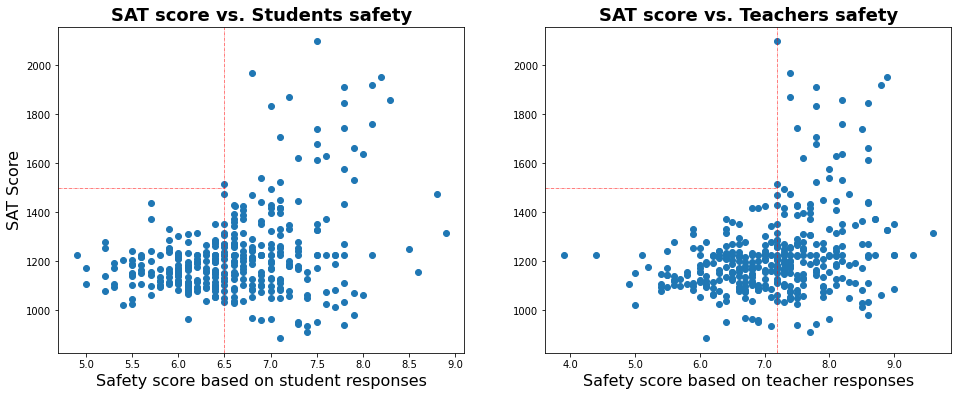

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Make a scatter plot of 'SAT score vs. Students safety'
ax[0].scatter(x=combined['saf_s_11'], y=combined['sat_score'])
ax[0].set_title('SAT score vs. Students safety', fontsize=18, fontweight='bold')
ax[0].set_xlabel('Safety score based on student responses', fontsize=16)
ax[0].set_ylabel('SAT Score', fontsize=16)
ax[0].axvline(x=6.5, linewidth=0.5, color='red', linestyle='-.')
ax[0].axhline(y=1500, xmax=0.41, linewidth=0.5, color='red', linestyle='-.')

# Make a scatter plot of 'SAT score vs. Teachers safety'
ax[1].scatter(x=combined['saf_t_11'], y=combined['sat_score'])
ax[1].set_title('SAT score vs. Teachers safety', fontsize=18, fontweight='bold')
ax[1].set_xlabel('Safety score based on teacher responses', fontsize=16)
# set float data type for ticks on the xaxis
ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[1].axvline(x=7.2, linewidth=0.5, color='red', linestyle='-.')
ax[1].axhline(y=1500, xmax=0.57, linewidth=0.5, color='red', linestyle='-.')

plt.show()

The scatter plots show two areas influencing the correlation between SAT scores and perceptions of safety and respect. **First**, the highest SAT scores come from schools with above averge perceptions of safety and respect. **Second**, it looks like most schools have both SAT and safety scores below the median values. It is also interesting that on average teachers have a noticeably higher perception of safety and respect than students.

For students it appears to be a correlation between SAT scores and saftey, although it isn't that strong. Majority of the students (around 58%) who responded are in the range of `6.0` and `7.2` with the approximate average SAT score of `1200`. Whereas, no school with a safety score lower than `6.5` has an average SAT score higher than `1500` or more.

On the other hand, 70 percent of the teachers who responded are in the range of `6.0` and `8.0` but they have the same average SAT score `1200`. For the most part, the schools with the safety score lower than `7.2` has average SAT score less than `1500`.

### 6. Compute Average of the Safety Score

Let's find the average safety score for each borough to get further useful information about the safety by the geographic area. We may also want to read up on the [boroughs of New York City](http://www.nycgo.com/boroughs-neighborhoods).

In [50]:
# Calculate borough average across all columns
boro_mean = combined.groupby('boro').agg(np.mean)

# Filter columns of interest and reset index
avg_saf_boro = boro_mean[['sat_score', 'saf_s_11', 'saf_t_11', 'saf_tot_11']].reset_index()

# List of columns to change the name in the 'avg_saft_boro'
updated_col_names = ['borough', 'sat_score', 'safety_student', 'safety_teacher', 'safety_total']

# Update column names
avg_saf_boro.columns = updated_col_names

# Display results
avg_saf_boro

,borough,sat_score,safety_student,safety_teacher,safety_total
0,Bronx,1157.598203,6.606577,7.026882,7.322581
1,Brooklyn,1181.364461,6.370755,6.985849,7.129245
2,Manhattan,1278.331410,6.831370,7.287778,7.473333
3,Queens,1286.753032,6.721875,7.365625,7.387500
4,Staten Island,1382.500000,6.530000,7.210000,7.200000


Grouping schools by borough and averaging scores paints a different picture. This seems to indicate that SAT sccores and perception of safety do not have a strong positive correlation at all. For instance, `Staten Island` has the highest average SAT scores and `Broxn` the lowest. However, the student and teacher perception of safety and respect scores are higher in the `Bronx` than in `Staten Island`. And while `Manhattan` has the highest total safety and respect scores, it ranks in the middle of SAT scores. So while using average for comparison is a start, the scatter plot charts show a much more granular view that is closer to reality. 

### 7. Investigate Racial Differences in SAT Score

There are a few columns that indicate the percentage of each race at given schools:

- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial difference in SAT performance.

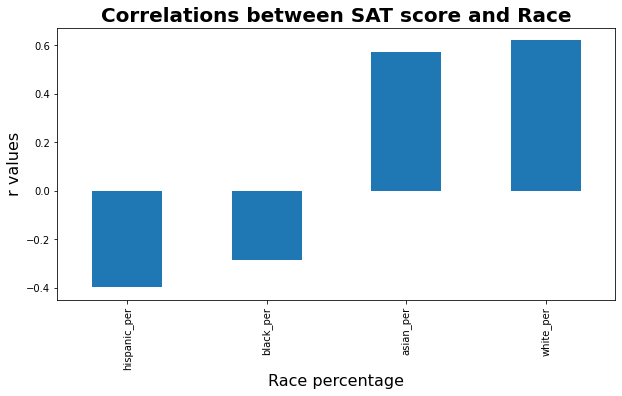

In [51]:
# Create list of target columns
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

# Make a bar plot of 'correlations' and 'race_cols'
create_bar(target_cols=race_cols, xlab='Race percentage', ylab='r values',
           title='Correlations between SAT score and Race', is_sorted=True, figsize=(10, 5))

There seems to be a fairly strong correlation. A higher percentage of White and Asian students at a school correlates positively with the SAT score, while schools with higher percentages of Hispanic and Black students tend to have lower SAT score.

This is a potentially sensitive topic, however let's explore further. Given what we see in the graph for Hispanic, let's zoom in further and find out schools with low SAT scores and high values.

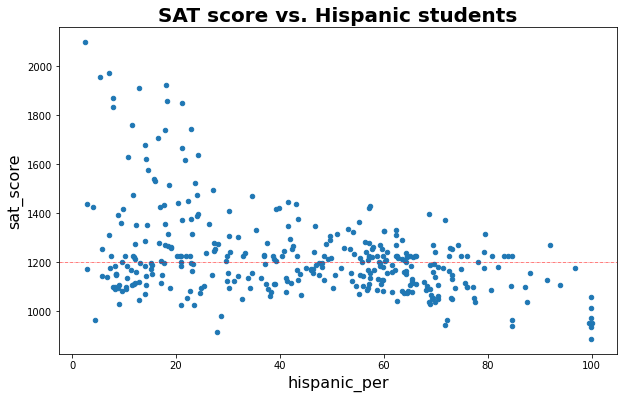

In [52]:
# Make a scatter plot of 'hispanic_per' vs. 'sat_score'
create_scatter(xcol='hispanic_per', xlab='hispanic_per', title='SAT score vs. Hispanic students',
               figsize=(10, 6), hline=True, ypos=1200)

The plot above seems to confirm the strong negative correlation; schools with higher percentages of Hispanic students tend to score lower SAT scores. At the far end of the graph, we see several schools with a percentage of (close to) 100%, with SAT scores around 1000 and below.

Let's continue our research further and find the school names and borough of these Hispanic students.

In [53]:
# Filter the schools with a 'hispanic_per' greater than '95%'
high_hisp_schools = combined[combined['hispanic_per'] > 95]

# Find the 'school names', 'borough', 'hispanic percentage',
# and 'sat score' from 'high_hisp_schools'.
# Show results in descending order
(high_hisp_schools[['SCHOOL NAME', 'boro',
                 'hispanic_per', 'sat_score']]
                 .sort_values(by='sat_score', ascending=False))

,SCHOOL NAME,boro,hispanic_per,sat_score
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,Manhattan,96.7,1174.0
44,MANHATTAN BRIDGES HIGH SCHOOL,Manhattan,99.8,1058.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,Manhattan,99.8,1014.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,Bronx,99.8,970.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,Bronx,99.4,951.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,Queens,100.0,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,Bronx,99.8,934.0
253,MULTICULTURAL HIGH SCHOOL,Brooklyn,99.8,887.0


A bit of research on these schools on the web indicates that these schools specifically target Spanish-speaking students, e.g. recent immigrants. A lower proficiency in English may lead to lower SAT scores.

Let's also take a look at the other end of the spectrum: schools with a low percentage of Hispanic students and high SAT scores.

In [54]:
# Filter 'hispanic_per' less than 10% and 'sat_score' greater than 1800
hisp_sat_score = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

# Find the 'school names', 'borough', 'hispanic percentage',
# and 'sat score' from 'hisp_sat_score'.
# Show results in descending order
(hisp_sat_score[['SCHOOL NAME', 'boro',
                 'hispanic_per', 'sat_score']]
                 .sort_values(by='sat_score', ascending=False))

,SCHOOL NAME,boro,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,Manhattan,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,Bronx,7.2,1969.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,Staten Island,5.3,1953.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,Queens,7.9,1868.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,Brooklyn,7.9,1833.0


Many of these schools seem to focus on science and technology. When looking them up on the web, we can find that many of them have admission tests. So the high SAT scores can possibly partially be explained by selection of students already prior to entering the school in the first place. This does not explain the low percentages of Hispanics; "proficiency in English" will play a role in being able to score on admission tests as well, and (at least for some) is even explicitly part of the admission tests.

### 8. Investigate Gender Differences in SAT scores

There are two columns that indicate the percentage of each gender at a shool:

- `male_per`
- `female_per`

We can plot the correlations between each gender percentage and `sat_score`.

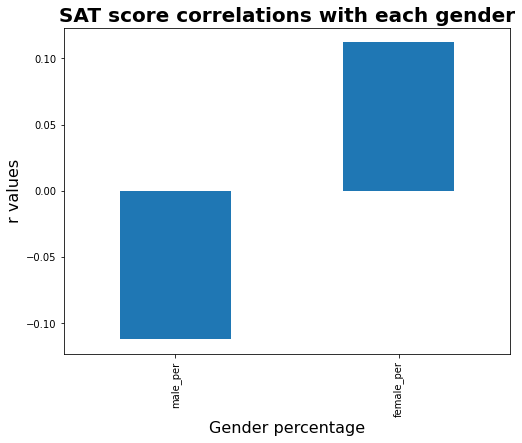

In [55]:
# Create list of target columns
gender_cols = ['male_per', 'female_per']

# Make a bar plot of 'correlations' and 'gender_corr'
create_bar(target_cols=gender_cols, xlab='Gender percentage', ylab='r values',
           title='SAT score correlations with each gender', figsize=(8,6))

A high percentage of female students seems to correlate with higher SAT scores, conversely, a higher percentage of male students correlates with lower SAT scores. Let's explore further and investigate schools with high SAT scores and a high `female_per`.

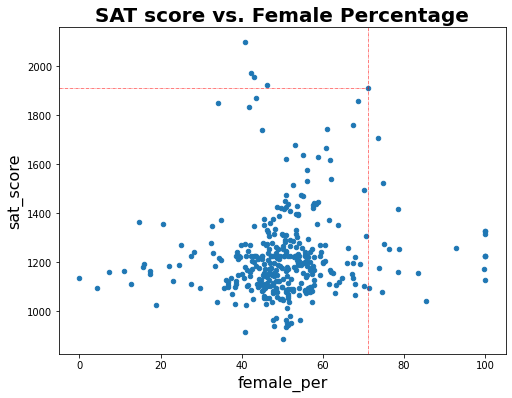

In [56]:
# Make a scatter plot of 'sat_score' vs. 'female_per' showing the
# highest point of sat score and female percentage
create_scatter(xcol='female_per', xlab='female_per', title='SAT score vs. Female Percentage',
               figsize=(8, 6), hline=True, ypos=1910, xmax=0.69, vline=True, xpos=71)

So actually the correlation between percentage of female students and SAT score doesn't seem to be that strong. The highest SAT scores are in schools with more mixed (male/female) populations, and the schools with the very highest percentages of female students do not score really high SAT score. The highest percentage female is 71% where the SAT score is around 1900.

Let's take a further look through and dig deeper on the cluster of schools with relatively high percentages of female students and high SAT score.

In [57]:
# Filter female percentage more than 60% and
# the SAT score above 1700
female_sat_score = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

# Find the 'school names', 'borough', 'female_per',
# and 'sat score' from 'female_sat_score'.
# Show results in descending order
(female_sat_score[['SCHOOL NAME', 'boro',
                 'female_per', 'sat_score']]
                 .sort_values(by='sat_score', ascending=False))

,SCHOOL NAME,boro,female_per,sat_score
302,TOWNSEND HARRIS HIGH SCHOOL,Queens,71.1,1910.0
5,BARD HIGH SCHOOL EARLY COLLEGE,Manhattan,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,Manhattan,67.5,1758.0
60,BEACON HIGH SCHOOL,Manhattan,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,Manhattan,73.6,1707.0


A brief look on the web for these schools seems to indicate that are just schools with high academic standards, and admission tests. What's interesting to see in the table above is that at least for these schools, the numbers of racial background vary significantly.

### 9. Calculate Students Percentage of AP Exam

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at at school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

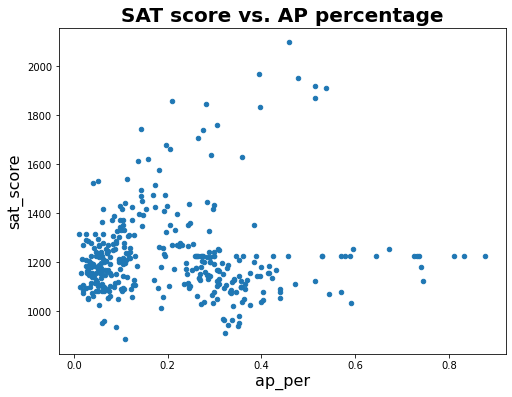

In [58]:
# Divide the 'AP Test Takers' column by the 'total_enrollment'
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

# Make a scatter plot of 'sat_score' vs. 'ap_per' to investigate
# the relationship between them
create_scatter(xcol='ap_per', xlab='ap_per', title='SAT score vs. AP percentage', figsize=(8, 6))

Not a very strong relationship. Higher percentages of students that take AP exams somewhat go hand-in-hand with SAT scores, but it does not look like a strong correlation.

### 10. SAT scores Per Borough and District

In our `combined` dataset we have, as we saw, data of 363 schools. Each school belongs to a school district, and each school district is in one of the 5 boroughs that make up New York. In this section we are going to explore to what extent the SAT score vary over these boroughs, and also over the districts within these boroughs.

Let's create aggregations, with average SAT scores at boro level and at district level.

In [104]:
# Check which districts exists
combined['school_dist'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

Among these 5 boros, we have 32 districts and 363 schools. For the purpose of our analysis we'll create a dataframe that only contains `boro`, `school_dist`, `DBN` and `sat_score` columns.

In [105]:
# Create a list of columns of interest
target_cols = ['boro', 'school_dist', 'DBN', 'sat_score']

# Create dataframe by filtering out 'target_cols'
# from 'combined' dataframe
filtered_combined = combined.loc[:, target_cols]
filtered_combined

,boro,school_dist,DBN,sat_score
0,Manhattan,01,01M292,1122.0
1,Manhattan,01,01M448,1172.0
2,Manhattan,01,01M450,1149.0
3,Manhattan,01,01M509,1207.0
4,Manhattan,01,01M539,1621.0
...,...,...,...,...
358,Brooklyn,32,32K545,1154.0
359,Brooklyn,32,32K549,1035.0
360,Brooklyn,32,32K552,1060.0
361,Brooklyn,32,32K554,1315.0


We can now find the average SAT score and school count based on each boro and district and gain insights into whether there's any effect on performance based on the location.

We can achieve these results using pandas `groupby()` method on `boro` and `school_dist` columns and find the schools count and average SAT scores using `DBN` and `sat_score`. We'll also make sure to pass `as_index=False` argument on groupby() to make `boro` and `school_dist` as dataframe columns again.

In [110]:
# Using 'filtered_combined' dataframe apply groupby() method
# and perform aggregation of the columns mentioned above
per_boro_dist_agg = filtered_combined.groupby(['boro', 'school_dist'], as_index=False).agg({'DBN': 'count', 'sat_score': 'mean'})

# Rename 'DBN' column to 'school_count'
per_boro_dist_agg.rename(columns={'DBN': 'school_count'}, inplace=True)

# Display sorted results by 'school_count' and 'sat_score'
# in descending order
per_boro_dist_agg.sort_values(by=['school_count', 'sat_score'], ascending=False)

,boro,school_dist,school_count,sat_score
19,Manhattan,02,48,1295.638184
3,Bronx,10,22,1222.227273
2,Bronx,09,20,1131.971940
4,Bronx,11,15,1165.000000
7,Brooklyn,14,14,1179.459915
10,Brooklyn,17,14,1161.428571
24,Queens,24,13,1242.000000
6,Brooklyn,13,13,1237.187600
0,Bronx,07,13,1128.846154
20,Manhattan,03,12,1293.443035


From our initial investigation, we see that the most number of schools (48) are from Manhattan in district 02 that are able achieve SAT score around 1295 on average. Whereas, there are 3 least performing schools who belong from Brooklyn in district 23 with average SAT score of 1157.

However, one thing to notice that 4 schools in district 22 also belong from Brooklyn who have the highest average SAT score among all others.

Let's further narrow down our investigation and find the sum of schools, count the districts, and calculate the average SAT score in each boroughs.

In [111]:
# Using 'per_boro_dist_agg' dataframe apply groupby() method to
# count 'school_dist', sum the 'school_count', and
# calculate the average of 'sat_score'
per_boro_agg = per_boro_dist_agg.groupby('boro', as_index=False).agg({'school_dist': 'count',
                                                                      'school_count': 'sum',
                                                                      'sat_score': 'mean'})

# Rename 'school_dist' to 'dist_count'
per_boro_agg.rename(columns={'school_dist': 'dist_count'}, inplace=True)

# View results
per_boro_agg

,boro,dist_count,school_count,sat_score
0,Bronx,6,93,1151.588938
1,Brooklyn,12,106,1193.163096
2,Manhattan,6,90,1269.571774
3,Queens,7,64,1293.865555
4,Staten Island,1,10,1382.500000


In the column `sat_score` above is representing the average of the average SAT score for per boro, hence it is incorrect. Let's calculate the correct value and replace.

In [115]:
# Calculate average in 'sat_score' per 'boro' from the
# 'filtered_combined'
sat_per_boro = filtered_combined.groupby('boro', as_index=False).agg({'sat_score': np.mean})
sat_per_boro

,boro,sat_score
0,Bronx,1157.598203
1,Brooklyn,1181.364461
2,Manhattan,1278.331410
3,Queens,1286.753032
4,Staten Island,1382.500000


We can now assign the above values in the `sat_score` column from `sat_per_boro` dataframe to `per_boro_agg` dataframe.

In [117]:
# Update the correct average value of 'sat_score' in 'per_boro_agg'
per_boro_agg['sat_score'] = sat_per_boro['sat_score']

# Display results
per_boro_agg

,boro,dist_count,school_count,sat_score
0,Bronx,6,93,1157.598203
1,Brooklyn,12,106,1181.364461
2,Manhattan,6,90,1278.331410
3,Queens,7,64,1286.753032
4,Staten Island,1,10,1382.500000


Let's create bar plots to show the relationship of average SAT score with each boro and district.